In [1]:
# importing librarys used in this Notebook 

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np 
import pandas as pd 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau

import cv2
import os


In [2]:
# set input file path to "/Downloads/chest_xray/" directory.

for dirname, _, filenames in os.walk('/Downloads/chest_xray/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

                           
# set subdirectory labels                           
sub_labels = ['PNEUMONIA', 'NORMAL']
    
# set image size
img_size = 150                           

## Function Blocks

In [3]:
# this function gets the data and assign to a variable

def get_data(dir_path):
         
    xray_data = [] 
    
    for label in sub_labels: 
        path = os.path.join(dir_path, label)
        class_num = sub_labels.index(label)
       
        for img in os.listdir(path):
            
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                xray_data.append([resized_arr, class_num])
            
            except Exception as e:
                print(e)
                
    return np.array(xray_data)

In [4]:
def get_X_y(tr,tt,vl):

#initalising variables
    x_tr = []
    y_tr = []

    x_vl = []
    y_vl = []

    x_tt = []
    y_tt = []

# prepare Train, Test, validate dataset
    for xray_img, img_label in tr:
        x_tr.append(xray_img)
        y_tr.append(img_label)

    for xray_img, img_label in tt:
        x_tt.append(xray_img)
        y_tt.append(img_label)
    
    for xray_img, img_label in vl:
        x_vl.append(xray_img)
        y_vl.append(img_label)
        
    # Normalize the data
    x_tr = np.array(x_tr) / 255
    x_vl = np.array(x_vl) / 255
    x_tt = np.array(x_tt) / 255

    # resize data for deep learning 
    x_tr = x_tr.reshape(-1, img_size, img_size, 1)
    y_tr = np.array(y_tr)

    x_vl = x_vl.reshape(-1, img_size, img_size, 1)
    y_vl = np.array(y_vl)

    x_tt = x_tt.reshape(-1, img_size, img_size, 1)
    y_tt = np.array(y_tt)
    
    return(x_tr, y_tr , x_vl, y_vl, x_tt, y_tt)

In [5]:
#This function displays x-rays given pict_id, title
def show_xray(pict_id, title):
    plt.figure(figsize = (5,5))
    plt.imshow(pict_id, cmap='gray')
    plt.title(title)
    

In [7]:
# This function prints the results after running CNN
def print_metrics(metric):
    print("Loss of the model is - " , round(metric[0]*100,2), "%")
    print("Accuracy of the model is - " , round(metric[1]*100,2) , "%")
   

In [8]:
# this function saves report to CSV

def classification_report_csv(report):
    report_data = []
    row = {}
    lines = report.split('\n')
    for line in lines[2:4]:
        
        row_data = line.split('      ')
        row['class'] = row_data[0]
        row['precision'] = float(row_data[1])
        row['recall'] = float(row_data[2])
        row['f1_score'] = float(row_data[3])
        row['support'] = float(row_data[4])
        report_data.append(row)
    dataframe = pd.DataFrame.from_dict(report_data)
    dataframe.to_csv('./downloads/classification_report.csv', index = False)




In [9]:
# Creating Confusion Matrix and display chart
def display_cm(data, pred):

    cm = confusion_matrix(data,pred)
    print(cm)

    cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

    plt.figure(figsize = (10,10))
    sns.heatmap(cm,cmap= "Blues", 
                linecolor = 'black' , 
                linewidth = 1 , 
                annot = True,
                annot_kws={"size":24},
                fmt='',
                xticklabels = sub_labels,
                yticklabels = sub_labels,
                )

    plt.ylabel('Predicted')
    plt.xlabel('Actual')
    
    return

In [10]:
# this function saves model.summary as .txt
def myprint(s):
    with open('model_summary_P_R.txt','a') as f:
        print(s, file=f)

In [42]:
  def display_xray_true_pos(data, pred, img_file):  
           
    pos = np.nonzero(data == pred)[0]
    
    i = 0
    for c in pos[-6:]:
        plt.subplot(3,2,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(img_file[c].reshape(img_size,img_size), cmap="gray", interpolation='none')
        plt.title("Predicted Class {},\n Actual Class {}".format(pred[c], data[c]))
        plt.tight_layout()
        i += 1

In [43]:
# This function displays X-rays which are correctly predicted
# identified
def display_xray_true_neg(data, pred, img_file):
    #Get predicted true samples
    neg = np.nonzero(data == pred)[0]
    
    #display 6 of them
    i = 0
    for c in neg[:6]:

        plt.subplot(3,2,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(img_file[c].reshape(img_size,img_size), cmap="gray", interpolation='none')
        plt.title("Predicted Class {}, \n Actual Class {}".format(pred[c],data[c]))
        plt.tight_layout()
        i += 1
   

## End of Function Block

## importing datasets

In [12]:
# read data into variables
train = get_data('./Downloads/chest_xray/train')
test = get_data('./Downloads/chest_xray/test')
val = get_data('./Downloads/chest_xray/val')

In [13]:
#number of data per category
print("There are " + str(len(train)) + " x-ray images in training dataset") 
print("\nThere are " + str(len(test)) + " x-ray images in testing dataset") 
print("\nThere are " + str(len(val)) + " x-ray images in validation dataset") 


There are 3752 x-ray images in training dataset

There are 1109 x-ray images in testing dataset

There are 995 x-ray images in validation dataset


C:\Users\Admin\anaconda3\envs\metis\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Training Dataset')

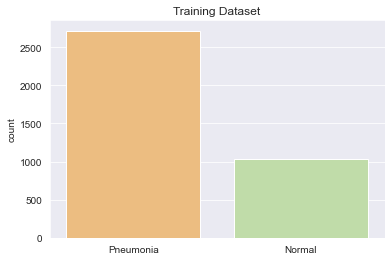

In [14]:
# display training dataset imbalance

l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")

sns.set_style('darkgrid')
sns.countplot(l,palette="Spectral")    
plt.title('Training Dataset')
   

C:\Users\Admin\anaconda3\envs\metis\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Testing Dataset')

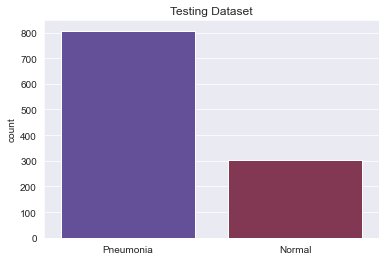

In [15]:
# display training dataset imbalance

l = []
for i in test:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")

sns.set_style('darkgrid')
sns.countplot(l,palette="twilight") 
plt.title('Testing Dataset')

C:\Users\Admin\anaconda3\envs\metis\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Validation Dataset')

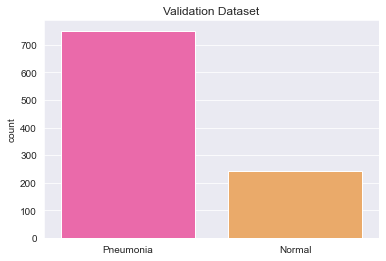

In [16]:
# display training dataset imbalance

l = []
for i in val:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")

sns.set_style('darkgrid')
sns.countplot(l,palette="spring") 
plt.title('Validation Dataset')

## Let's look at Normal Vs Infected patient X-ray images

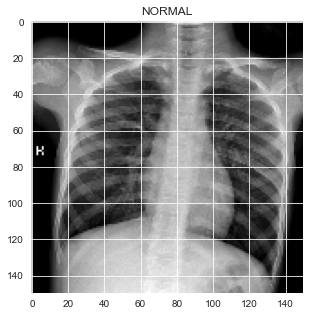

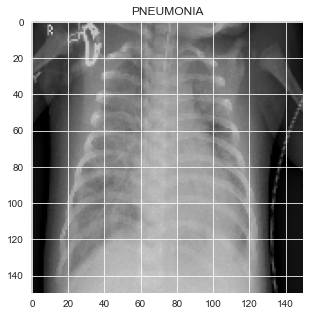

In [17]:
show_xray(train[-1][0],sub_labels[train[-1][1]])
show_xray(train[0][0],sub_labels[train[0][1]])


In [18]:
# Getting Training, Testing and Validating Dataset from function
x_train, y_train , x_val, y_val, x_test, y_test = get_X_y(train,test,val)

In [19]:
# Data Augmentation for data imbalance

img_datagen = ImageDataGenerator(
    rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.2, # Randomly zoom image 
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip = True,  # randomly flip images
    ) 
img_datagen.fit(x_train)


In [20]:
# List for layers for CNN

model = Sequential()

#Convolutional Layer 1
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

#Convolutional Layer 2
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

#Convolutional Layer 3
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

#Convolutional Layer 4
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

#Convolutional Layer 5
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

#Flatten and full connection layers
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))

#Complie the CNN layers
model.compile(optimizer = "Adamax" , 
              loss = 'binary_crossentropy' , 
              metrics = ['Accuracy'])

## Setup the CNN

In [21]:
#Show CNN Summary
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 38, 64)        0

In [22]:
# save CNN Summary to .txt
summary = model.summary(print_fn = myprint)


In [24]:
# set early stop conditions
early_stop = EarlyStopping(monitor='val_accuracy',patience=2, verbose = 1, restore_best_weights=True)

In [25]:
history = model.fit(
    img_datagen.flow(x_train,y_train,
                     batch_size = 32,
                     seed=888),#X_y_train,
    epochs = 12 , 
    steps_per_epoch=len(x_train) / 32,
    validation_data = img_datagen.flow(x_val, y_val,
                                       batch_size = 32,
                                       seed=888), #X_y_val,
    callbacks = [early_stop])

Epoch 1/12
118/117 [==============================] - 181s 2s/step - loss: 0.3696 - accuracy: 0.8779 - val_loss: 3.9637 - val_accuracy: 0.7548
Epoch 2/12
118/117 [==============================] - 183s 2s/step - loss: 0.1953 - accuracy: 0.9211 - val_loss: 5.5510 - val_accuracy: 0.7548
Epoch 3/12
118/117 [==============================] - ETA: -1s - loss: 0.1784 - accuracy: 0.9296
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
118/117 [==============================] - 181s 2s/step - loss: 0.1784 - accuracy: 0.9296 - val_loss: 3.9938 - val_accuracy: 0.7548
Epoch 4/12
118/117 [==============================] - 182s 2s/step - loss: 0.1435 - accuracy: 0.9456 - val_loss: 3.5454 - val_accuracy: 0.7548
Epoch 5/12
118/117 [==============================] - 196s 2s/step - loss: 0.1319 - accuracy: 0.9539 - val_loss: 1.8047 - val_accuracy: 0.7558
Epoch 6/12
118/117 [==============================] - 187s 2s/step - loss: 0.1365 - accuracy: 0.9480 - val_loss: 0.6797

In [38]:
# saving trained model to file
model.save('./Downloads/2020_11_17_r1.h5')

In [39]:
# saving history to file
np.save('./Downloads/2020_11_17_r1.npy',history.history)

In [28]:
#history=np.load('./Downloads/2020_11_acc9636_history.npy',allow_pickle='TRUE')

In [29]:

#model = keras.models.load_model('./Downloads/2020_11_04_acc9603.h5')


In [30]:
#Print Results
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

35/35 [==============================] - 10s 279ms/step - loss: 0.2593 - accuracy: 0.9152
Loss of the model is -  0.25934281945228577
35/35 [==============================] - 10s 281ms/step - loss: 0.2593 - accuracy: 0.9152
Accuracy of the model is -  91.52389764785767 %


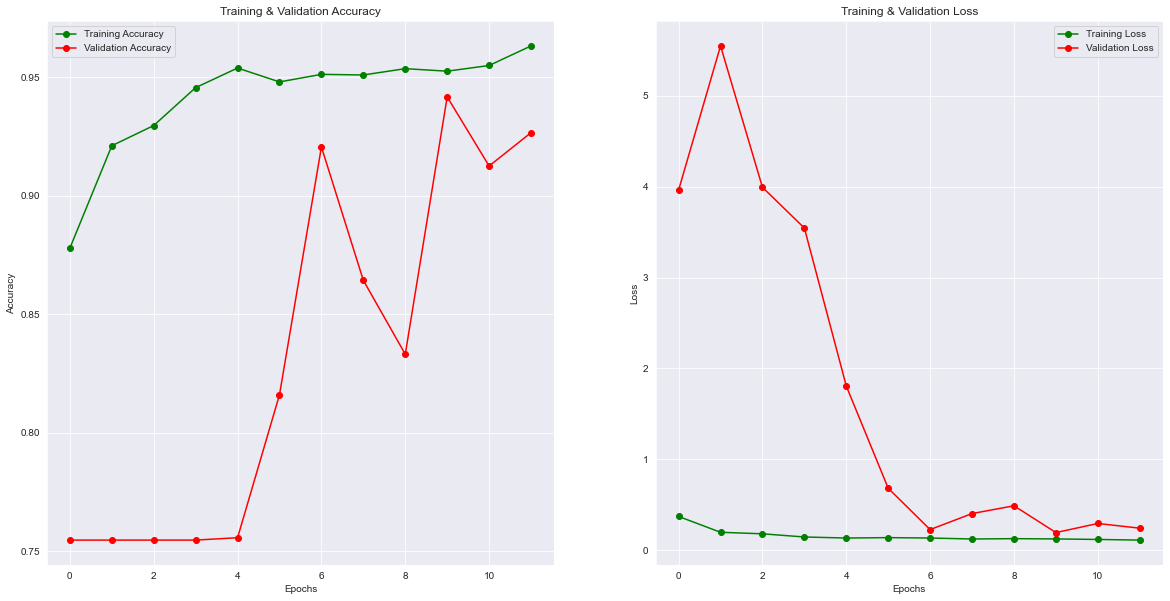

In [31]:
#Print Accuracy and loss charts
epochs = [i for i in range(len(history.history['loss']))]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Training & Validation Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [32]:
# Running Model on Testing Dataset
predictions = " "
predictions = (model.predict(x_test) > 0.5).astype("int32")
#predictions = model.predict_classes(x_test)
predictions = predictions.reshape(1,-1)[0]


In [33]:
print(predictions)

[0 0 0 ... 1 1 1]


In [34]:
# Get report and print
report = classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)'])

print(report )

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.92      0.96      0.94       807
   Normal (Class 1)       0.89      0.78      0.83       302

           accuracy                           0.92      1109
          macro avg       0.91      0.87      0.89      1109
       weighted avg       0.91      0.92      0.91      1109



In [35]:
#save report as CSV
classification_report_csv(report)

[[778  29]
 [ 65 237]]


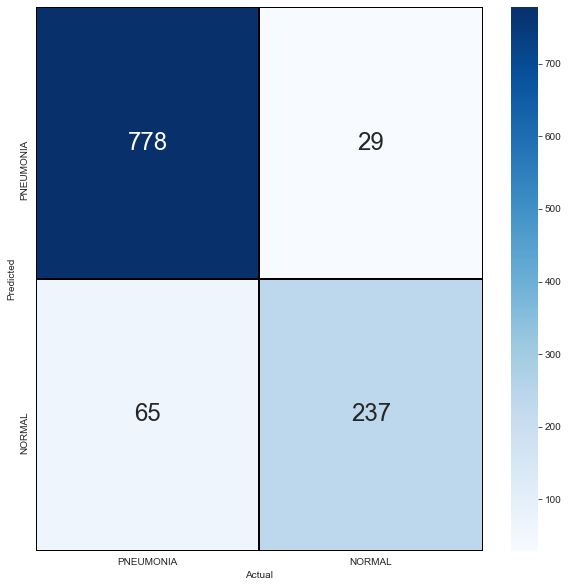

In [36]:
# Creating Confusion Matrix and display chart
display_cm(y_test,predictions)

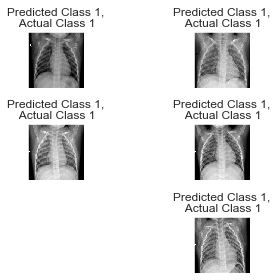

In [44]:
display_xray_true_pos(y_test, predictions,x_test)

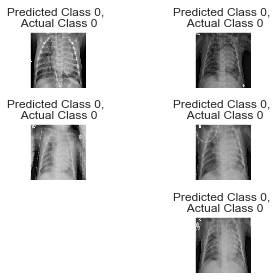

In [45]:
display_xray_true_neg(y_test, predictions,x_test)